In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as linalg
import numpy.random as rnd
import networkx as nx

## A handy function for drawing graphs: `draw_from_matrix`

In [2]:
def draw_from_matrix(A,draw_labels=False) :
  G = nx.from_numpy_matrix(np.matrix(A), create_using=nx.DiGraph)
  layout = nx.spring_layout(G,seed=0)
  nx.draw(G, layout, node_size=750, with_labels=True, font_weight='bold', font_size=15, connectionstyle='arc3, rad = 0.1')
  if draw_labels :
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels, label_pos=.33);

## Create an adjacency matrix to play with. Recall:
- A is a weighted nxn adjacency matrix
- $\lambda_i$ is the susceptibility of node $i$
- $\Lambda$ is a diagonal matrix defined as ${\rm diag}(\lambda_1,\lambda_2,\dots,\lambda_n)$

In [3]:
A = np.array([[.25,.25,.5],
              [1/3,1/3,1/3],
              [1/9,2/9,2/3]])
onevec = np.array([[1,1,1]]).T
lambdas = np.array([1,1,.99])
Lam = np.diag(lambdas)
print('A:\n' + str(A))
print('\nlambdas:\n' + str(lambdas))
print('\nLam:\n' + str(Lam))

A:
[[0.25       0.25       0.5       ]
 [0.33333333 0.33333333 0.33333333]
 [0.11111111 0.22222222 0.66666667]]

lambdas:
[1.   1.   0.99]

Lam:
[[1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   0.   0.99]]


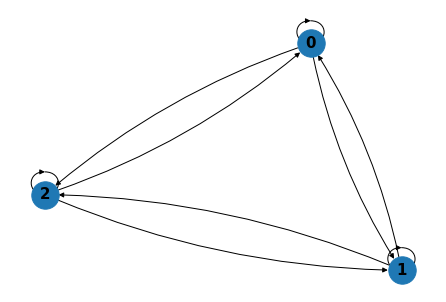

In [4]:
draw_from_matrix(A)

## Check that $A$ is row-stochastic by taking large matrix powers:

In [5]:
A@A@A@A@A@A@A

array([[0.1951237 , 0.25609808, 0.54877822],
       [0.19513587, 0.25610169, 0.54876244],
       [0.19511483, 0.25609545, 0.54878972]])

In [6]:
linalg.matrix_power(A,100000)

array([[0.19512195, 0.25609756, 0.54878049],
       [0.19512195, 0.25609756, 0.54878049],
       [0.19512195, 0.25609756, 0.54878049]])

In [7]:
linalg.matrix_power(A,100000)@onevec

array([[1.],
       [1.],
       [1.]])

## On the board, we showed that 
$$x(t) = (\Lambda A)^tx(0) + \left[ \sum_{i=0}^{t-1}(\Lambda A)^i \right] (I-\Lambda)x(0)$$

But then we showed that a couple weird facts are always true: 
- $\lim_{t\to\infty}(\Lambda A)^t = 0_{n\times n} $  (a matrix of all 0's)
- and that $\left[ \sum_{i=0}^{t-1}(\Lambda A)^i\right] = (I-\Lambda A)^{-1}.$

Let's verify those in code:

## Check that if you take many matrix powers of $\Lambda A$ that it goes to 0:

In [8]:
(Lam@A)@(Lam@A)@(Lam@A)@(Lam@A)@(Lam@A)@(Lam@A)@(Lam@A)@(Lam@A)@onevec

array([[0.96281449],
       [0.96493873],
       [0.95120082]])

In [9]:
linalg.matrix_power(Lam@A,100000)@onevec

array([[2.37027481e-239],
       [2.37550441e-239],
       [2.34168398e-239]])

## Want to write code to verify that $\lim\limits_{t\to\infty}\left[ \sum\limits_{i=0}^{t-1} (\Lambda A)^i \right] = (I-\Lambda A)^{-1}$. 

First, create a function which computes the series $\lim\limits_{t\to\infty}\left[ \sum\limits_{i=0}^{t-1} (\Lambda A)^i \right]$.

In [10]:
def compute_series(Lam,A,k) :
  n = A.shape[0] # assuming that A is nxn matrix
  accum = np.zeros((n,n))
  for i in range(k) :
    accum += linalg.matrix_power(Lam@A,i)
  return accum

Then use it to compute the series:

In [11]:
compute_series(Lam,A,10000)

array([[ 36.8,  46.8, 100. ],
       [ 36. ,  48. , 100. ],
       [ 35.2,  46.2, 100. ]])

Now, compute the matrix inverse. Use the function `np.eye(n)` to create an identity matrix of size `n`, and the function `la.inv()` to compute the matrix inverse directly:

In [12]:
linalg.inv(np.eye(3)-Lam@A)

array([[ 36.8,  46.8, 100. ],
       [ 36. ,  48. , 100. ],
       [ 35.2,  46.2, 100. ]])

Ta-da!

## Now, implement the whole Friedkin-Johnsen model:

In [13]:
def friedkin_johnsen(Lam,A,x0,k,plot_result = False) :
  n = A.shape[0] # assuming everything is dimensioned right
  I = np.eye(n)
  xx = np.zeros((n,k))
  xx[:,0] = x0
  for i in range(1,k) :
    xx[:,i] = Lam@A@xx[:,i-1] + (I-Lam)@x0
  if plot_result:
    plt.plot(xx.T)
  return xx 

And call the function with some predefined initial opinions:

In [14]:
x0 = np.array([0,.5,.8])
result = friedkin_johnsen(Lam,A,x0,1000) # result is a pretty big vector, so we don't want to print it
print(result[:,-1])  # instead, just print the last one

[0.79902954 0.7990274  0.79904124]


We can also plot the opinions over time:

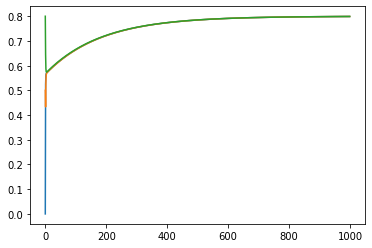

In [15]:
friedkin_johnsen(Lam,A,x0,1000,plot_result=True);

## Make it interesting

That one was super uninteresting because most of the Lambdas were very close to 1. What if lambdas are different?

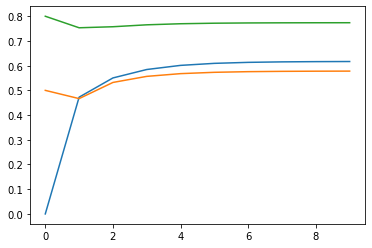

In [16]:
A2 = np.matrix([[.25,.25,.5],
              [1/3,1/3,1/3],
              [1/9,2/9,2/3]])
lambdas2 = np.array([.9,.5,.3])
Lam2 = np.diag(lambdas2)
x02 = np.array([0,.5,.8])
friedkin_johnsen(Lam2,A2,x02,10,plot_result=True);

## Now let's do this with a bigger, more interesting graph

Famous graph model: the [Barabasi-Albert Model](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model)
Basic idea: start with a connected graph, then go around the circle, add $m$ links from each node, connecting those links to other nodes randomly but making it more likely to connect to high-degree nodes than low-degree.

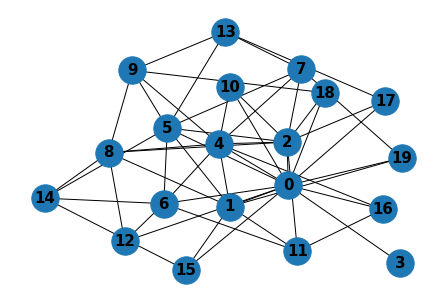

In [17]:
Gba = nx.barabasi_albert_graph(20,3,seed=0)
layout = nx.kamada_kawai_layout(Gba)
nx.draw(Gba,pos=layout, node_size=750, with_labels=True, font_weight='bold', font_size=15,)

## Now convert that graph to an adjacency matrix:

In [18]:
Aba = nx.to_numpy_array(Gba)
print(Aba)

[[0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.

## We can't use that matrix directly, since it's not row-stochastic. We'll make it row-stochastic in a simple way, by normalizing every row to make it sum to 1.

This means we need to multiply each row $i$ by a number, and we know we can do that with a diagonal matrix. What number? $1/d_i$, where $d_i$ is the degree of node $i$.

First, get the degrees by right-multiplying by a column vector of 1's:

In [19]:
Aba_degrees = Aba@np.ones((20,1))
print(Aba_degrees)

[[13.]
 [ 7.]
 [ 9.]
 [ 1.]
 [ 9.]
 [ 8.]
 [ 6.]
 [ 5.]
 [ 6.]
 [ 5.]
 [ 3.]
 [ 4.]
 [ 3.]
 [ 4.]
 [ 4.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]
 [ 3.]]


Next, form that vector of degrees into a diagonal matrix:

In [20]:
Aba_degrees_diag = np.diag(1/Aba_degrees[:,0])
print(Aba_degrees_diag)

[[0.07692308 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.14285714 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.11111111 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.11111111 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.


Finally, multiply the new diagonal matrix onto $A$:

In [21]:
Aba_row_stochastic = Aba_degrees_diag@Aba

How do we verify that the new matrix is actually row stochastic? We sum the rows by multiplying by a vector of 1's:

In [22]:
Aba_row_stochastic @ np.ones((20,1))

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

## Now use this new row-stochastic matrix to define a Friedkin-Johnsen model!

First need some lambdas and initial opinions. let's choose lambdas randomly:

In [23]:
rnd.seed(0) # do this so we get the same "random" result every time! If you want a different result, change the 0 to something else
lambdas_ba = rnd.rand(20)
Lam_ba = np.diag(lambdas_ba)

Now, initial opinions. For fun, let's give nodes 0 and 1 (highly connected) an opinion of 1, and everybody else an opinion of 0:

In [24]:
starting_list = [1]*2 + [0]*18
x0_ba = np.array(starting_list)

Now let's do this! Run the model and generate the plot:

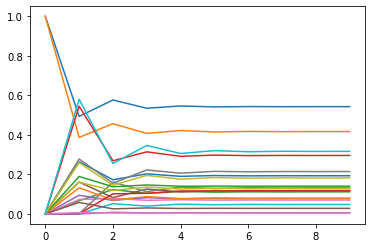

In [25]:
result = friedkin_johnsen(Lam_ba,Aba_row_stochastic,x0_ba,10,plot_result=True)